In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True

In [ ]:

DATA_PATH = './Data/datos_lab3.csv'
df = pd.read_csv(DATA_PATH)

cols = [c.lower().strip() for c in df.columns]
df.columns = cols

if 'x' not in df.columns or 'y' not in df.columns:
    if df.shape[1] >= 2:
        df = df.rename(columns={df.columns[0]: 'x', df.columns[1]: 'y'})
    else:
        raise ValueError("No se encontraron columnas 'x' y 'y' en el CSV.")

df = df[['x','y']].copy()
df = df.sort_values('x').reset_index(drop=True)
n = len(df)
display(df.head(10))
print(f"n = {n} muestras")


,x,y
0,0.00,2.831309
1,0.01,1.449217
2,0.02,2.032232
3,0.03,1.900237
4,0.04,3.258873
5,0.05,2.245591
6,0.06,2.545671
7,0.07,3.118162
8,0.08,1.971564
9,0.09,2.017069


n = 1001 muestras


In [4]:
def design_matrix(x):
    # X = [1, x, x^2, sin(7x), sin(13x)]
    x = np.asarray(x).reshape(-1)
    return np.column_stack([
        np.ones_like(x),
        x,
        x**2,
        np.sin(7*x),
        np.sin(13*x),
    ])

def build_difference_operator(X):
    # (A @ beta)_i = f(x_{i+1}) - f(x_i) = (X[i+1]-X[i]) @ beta
    return X[1:] - X[:-1]

def objective_and_grad(beta, X, y, lam):
    # E_lambda = ||X beta - y||^2 + lam * ||A beta||^2
    # grad = 2 X^T (X beta - y) + 2 lam A^T A beta
    
    A = build_difference_operator(X)
    r = X @ beta - y
    Ab = A @ beta
    E = np.dot(r, r) + lam * np.dot(Ab, Ab)
    grad = 2 * (X.T @ r + lam * (A.T @ Ab))
    return E, grad

def closed_form_solution(X, y, lam):
    # (X^T X + lam A^T A) beta = X^T y
    A = build_difference_operator(X)
    H = X.T @ X + lam * (A.T @ A)
    b = X.T @ y
    try:
        beta = np.linalg.solve(H, b)
    except np.linalg.LinAlgError:
        beta = np.linalg.lstsq(H, b, rcond=None)[0]
    return beta

def predict(X, beta):
    return X @ beta

x = df['x'].to_numpy()
y = df['y'].to_numpy()
X = design_matrix(x)
p = X.shape[1]

print("Dimensiones: X =", X.shape, "  y =", y.shape)


Dimensiones: X = (1001, 5)   y = (1001,)


In [5]:
lambdas = [0, 100, 500]
solutions = {}
for lam in lambdas:
    beta = closed_form_solution(X, y, lam)
    yhat = predict(X, beta)
    mse = np.mean((y - yhat)**2)
    A = build_difference_operator(X)
    smooth = np.sum((A @ beta)**2)
    solutions[lam] = {
        'beta': beta,
        'mse': mse,
        'smooth_term': smooth,
    }

pd.DataFrame({
    'lambda': lambdas,
    'beta0': [solutions[L]['beta'][0] for L in lambdas],
    'beta1': [solutions[L]['beta'][1] for L in lambdas],
    'beta2': [solutions[L]['beta'][2] for L in lambdas],
    'beta3': [solutions[L]['beta'][3] for L in lambdas],
    'beta4': [solutions[L]['beta'][4] for L in lambdas],
    'MSE (datos)': [solutions[L]['mse'] for L in lambdas],
    '||A beta||^2 (suavidad)': [solutions[L]['smooth_term'] for L in lambdas],
})


,lambda,beta0,beta1,beta2,beta3,beta4,MSE (datos),||A beta||^2 (suavidad)
0,0,3.048712,0.014697,-0.003463,5.250387,-4.666262,1.042821,254.295953
1,100,3.005094,0.058253,-0.009276,3.500502,-1.720727,6.892727,55.776568
2,500,3.118076,0.036131,-0.009382,1.501870,-0.486344,16.738020,7.622362


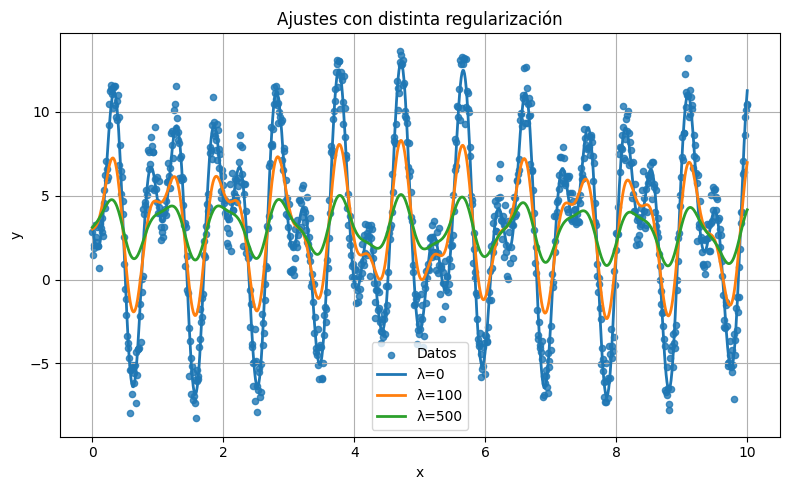

In [7]:
xx = np.linspace(df['x'].min(), df['x'].max(), 800)
XX = design_matrix(xx)

plt.figure()
plt.scatter(df['x'], df['y'], s=20, label='Datos', alpha=0.8)
 
styles = {0:'-', 100:'-', 500:'-'}
for lam in [0, 100, 500]:
    yy = predict(XX, solutions[lam]['beta'])
    plt.plot(xx, yy, styles[lam], linewidth=2, label=f'λ={lam}')

plt.title('Ajustes con distinta regularización')
plt.xlabel('x'); plt.ylabel('y')
plt.legend()
plt.tight_layout()
plt.show()